# Tarea 3 - Parte 2
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

## 2. *Question Answering*

Las redes neuronales recurrentes hoy en día han sido aplicadas a varios problemas que involucra dependencia temporal de los datos de entrada, en textos por lo común, tal como los modelos *sequence to sequence* de traducción, resumir textos, formular hipótesis de un extracto o, como veremos en esta actividad, generar respuesta en base a alguna pregunta. En imágenes también han sido aplicadas, ya sea a procesamiento de videos u a otro problema en que las imágenes tienen dependencia temporal unas con otras.

Para ésta actividad trabajaremos el dataset de __[SQuAD2.0](https://rajpurkar.github.io/SQuAD-explorer/)__  (The Stanford Question Answering Dataset), los datos se los entregamos en formato *csv*, sin ningún preprocesamiento, para que sea mas fácil la lectura. La tarea como ya se comentó consiste en predecir una respuesta (secuencia de palabras) que contesten una pregunta también en forma de secuencia de palabras, con un enfoque *encoder-decoder* con módulos de antención.


<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/07/20/sockeye_1.gif" title="Attention" width="65%" style="float: right;"/>


<img src="http://www.wildml.com/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.16.08-PM.png" title="Attention" width="35%" style="float: left;"/>



Los módulos de antención [[6]](#refs) son una variación a la arquitectura *encoder-decoder* en donde se agrega que para cada instante de tiempo de la **decodificación** $T'$ hay una combinación lineal del vector de codificación en todos los instantes tiempo $T$, ésto es para que en cada instante de tiempo de la decodificación se ponga atención a cierta información en toda la secuencia de entrada. 


$$
y_{T'} = \sum_{t}^{T} \alpha_{T',t} \cdot h_t^{codificacion}
$$

> a) Carge los datos y descríbalos ¿Cuántos ejemplos se tienen para entrenar y para predecir?


In [1]:
import pandas as pd
import time, os
from collections import defaultdict


df_train = pd.read_csv(os.path.join(os.getcwd(),'data','train_Q-A.csv'))
df_train.dropna(inplace=True)
df_test = pd.read_csv(os.path.join(os.getcwd(),'data','test_Q.csv'))

In [2]:
df_train.head()

,id,question,answer
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,in the late 1990s
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,singing and dancing
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,2003
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,late 1990s


In [3]:
df_test.head()


,id,question
0,56ddde6b9a695914005b9628,In what country is Normandy located?
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?
3,56ddde6b9a695914005b962b,Who was the Norse leader?
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...


In [4]:
print("Existen un total de  {} preguntas".format(len(df_train['question'])))
print("Y un total de {} respuestas".format(len(df_train['answer'])))


print("En cuanto a las preguntas para predecir se tiene que son un total de {}".format(
   len(df_test['question']) ))

Existen un total de  86821 preguntas
Y un total de 86821 respuestas
En cuanto a las preguntas para predecir se tiene que son un total de 11873


Existen un total de  86821 preguntas
Y un total de 86821 respuestas
En cuanto a las preguntas para predecir se tiene que son un total de 11873

> b) Realice un preprocesamiento simple a los textos de entrada (preguntas) *tokenizandolos* y pasando a minúsculas para evitar ambiguedad, si desea agregar algun preprocesamiento éxtra ésto se verá reflajado en su nota. A los textos de salida (respuestas) no realice ningún preprocesamiento mas que *tokenizar*, puesto que para la evaluación se solicita retornar los textos en su forma natural. Comente lo realizado.


In [5]:
from nltk.tokenize import word_tokenize
train_questions = [word_tokenize(sentence.lower()) for sentence in df_train["question"]] #or processing
test_questions = [word_tokenize(sentence.lower()) for sentence in df_test["question"]]
train_answers = [word_tokenize(sentence) for sentence in df_train["answer"]]

> c) Cree un vocabulario para codificar las palabras en las respuestas a generar. Repita el procedimiento para las preguntas. Agrege un símbolo que signifique el fin de la respuesta a generar, así para tener un criterio de cuando una respuesta, valga la redundancia, está efectivamente *respondida* ¿Cuántas palabras tiene el vocabulario de las respuestas y de las preguntas? ¿Ésto podría ser un problema al momento de entrenar la red para que predizca de entre todas ellas?

In [6]:
vocab_answer = set()
for sentence in train_answers:
    for word in sentence:
        vocab_answer.add(word)
vocab_answer = ["#end"]+ list(vocab_answer)
print('posibles palabras para respuestas: {}'.format(len(vocab_answer)))
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}

vocab_question = set()
for sentence in train_questions+test_questions:
    for word in sentence:
        vocab_question.add(word)
vocab_question = list(vocab_question)
print('posibles palabras para preguntas: {}'.format(len(vocab_question)))
vocabQ_indices = {c: i for i, c in enumerate(vocab_question)}

posibles palabras para respuestas: 47423
posibles palabras para preguntas: 42059


El vocabulario es de 47423 y 42059 palabras para respuestas y preguntas respectivamente

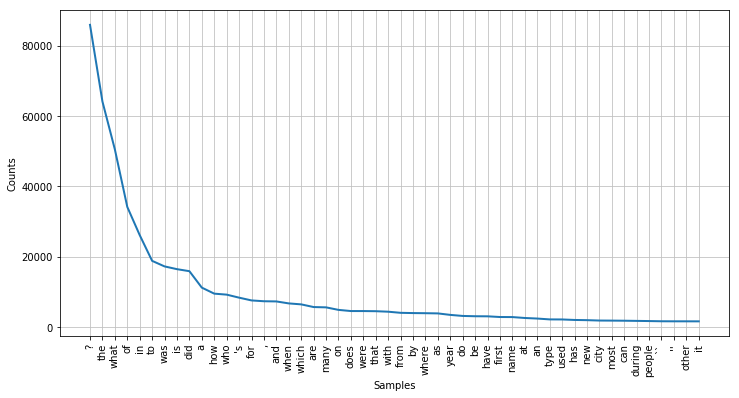

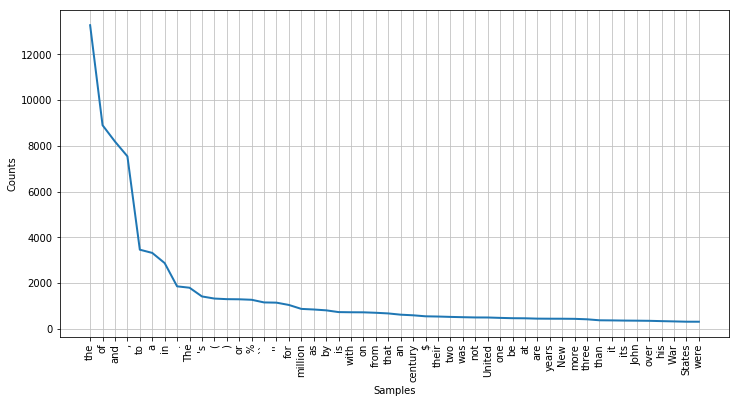

In [49]:
import nltk
import matplotlib.pyplot as plt
words_q = np.asarray(train_questions).flatten()
words_a =  np.asarray(train_answers).flatten()
words_q = np.concatenate(words_q).ravel()
words_a = np.concatenate(words_a).ravel()

fdist1 = nltk.FreqDist(words_q)
fdist2 = nltk.FreqDist(words_a)
plt.figure(figsize=(12,6))
fdist1.plot(50)
plt.figure(figsize=(12,6))
fdist2.plot(50)

Se visualiza el ranking de palabras, de los vocabularios de preguntas y respuestas, se pueden observar posibles problemas como el exceso de simbolos, se tiene la conjetura que puede ocasionar problemas para la legibilidad de la construcción de respuestas.

> d) Codifique los tokens (palabras) de cada texto que utilizará.

Se codifican los tokens en un vector, el cual contiene la codificación de los tokens en números
['in', 'the', 'late', '1990s'] es equivalente a [24348, 12119, 40759, 5167]

In [11]:
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtrain_question = [[vocabQ_indices[palabra] for palabra in sentence] for sentence in train_questions]
Xtest_question = [[vocabQ_indices[palabra] for palabra in sentence] for sentence in test_questions]


> Luego de ésto realice un *padding* a ambas secuencias, entrada y salida de entrenamiento y a la entrada del conjunto de pruebas. Comente sobre las dimensionalidades finales de los conjuntos de entrenamiento y de prueba.

Dada a la diferencia de los largos de las respuestas se procesan para dejarlas todas en un largo estandar, el cual va a ser input del modelo

In [14]:
import numpy as np
max_input_lenght = np.max(list(map(len,train_questions)))
max_output_lenght = np.max(list(map(len,train_answers)))+1

from keras.preprocessing import sequence

Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='post',value=0)
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='post',value=0)
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='post',value=vocabA_indices["#end"])


c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


> Defina la atención $\alpha$ que se calculará sobre cada instante de tiempo $T$ computándo su atención en cada instante de tiempo de la decodificación $T'$.


Para esta parte se decide separar el codigo dado a que existen muchos problemas de incoherencias producidas por el estilo flexible de los notebooks, Se separa cada modelo en su propio scriptn, cada modelo cubre la parte de la definición del encoder decoder con el modulo de atencion y el entrenamiento , si se descomenta las siguientes lineas se puede observar, pero estos scripts estan ideados para ser ejecutados en consola.

In [ ]:
# %load QA.py

el primer modelo es tal cual como lo espresado en el enunciado, con compuerta de tipo CuDNNGRU

In [ ]:
# %load QA model 2.py

el segundo modelo consta de una compuerta CuDNNLSTM

In [ ]:
# %load QA model 3.py

el modelo 3 consta de compuerta del tipo Simple_RNN

In [ ]:
# %load QA model 4.py

Como variación se usa el modelo 4 con una compuerta bidireccional, sobre una compuerta LSTM

> g) Mostrar ejemplos

In [ ]:
resultados_path = os.path.join(os.getcwd(),'results')
model1 = load_model(os.path.join(resultados_path,'model_CuDNNGRU_.h5'))
model2 = load_model(os.path.join(resultados_path,'model_CuDNNLSTM_.h5'))
model3 = load_model(os.path.join(resultados_path,'model_RNN_.h5'))
#model4 = load_model(os.path.join(resultados_path,'model_Bidirectional_.h5'))

In [ ]:
df_test = pd.read_csv(os.path.join(os.getcwd(),'data','test_Q.csv'))

with open(os.path.join(os.getcwd(),'temp','Xtest_question.pickle'),'rb') as p_file:
    Xtest_question = pickle.load(p_file)
with open(os.path.join(os.getcwd(),'temp','vocab_answer.pickle'),'rb') as p_file:
    vocab_answer = pickle.load(p_file)
with open(os.path.join(os.getcwd(),'temp','vocab_question.pickle'),'rb') as p_file:
    vocab_question = pickle.load(p_file)
with open(os.path.join(os.getcwd(),'temp','vocabQ_indices.pickle'),'rb') as p_file:
    vocabQ_indices = pickle.load(p_file)
with open(os.path.join(os.getcwd(),'temp','indices_vocabA.pickle'),'rb') as p_file:
    indices_vocabA = pickle.load(p_file)

In [135]:
# Se define diversity como la probabilidad de elegir otra elemento entre el segundo al cuarto con mas probabilidad
def predict_words(model, example,diversity=0):
    prediction = model.predict(example)
    prediction = prediction.reshape(prediction.shape[1:])
    palabra_elegida = np.array([])
    for p_palabra in prediction:
        p_palabra = p_palabra/np.sum(p_palabra)
        palabra_elegida = np.append(
            palabra_elegida, np.random.choice(p_palabra.shape[0], p=p_palabra))
        if np.random.binomial(n=1,p=diversity):
            palabra_elegida = palabra_elegida[:-1]
            idx = np.random.randint(2,4)
            palabra_elegida = np.append(
            palabra_elegida, np.argsort(p_palabra)[::-1][idx])
            
    return palabra_elegida

In [ ]:
def show_examples(model, indexs):

    for i in range(len(indexs)):
        #indexs = np.random.randint(0,len(Xtest_question))
        example = Xtest_question[indexs[i]]
        example = example.reshape((1,60,))
        indexes_answer = predict_words(model, example)

        question = df_test["question"][indexs[i]]
        print("Pregunta: ", question)
        answer = ""
        for index in indexes_answer:
            if indices_vocabA[index] == "#end":  # el final de la oracion
                continue
            else:
                answer += indices_vocabA[indexs[i]] + " "
        print("Respuesta: ", answer)
    print("Los ha predecido todos!")

Pequeña muestra aleatoria de indices de preguntas, las cuales se contrasta a lo largo de los diferentes modelo.

Se puede observar que a lo largo de los tres modelos, se obtienen resultados similares, pero diferente en el los largos de respuestas obtenidos, esto se puede deber al tratamiento de la marca #End que indica el fin de la respuesta, también se observa esto cuando se elige una diversidad mayor a la definida, las respuestas incrementan en su largo.

> h) Evalúe la calidad de su modelo con la métrica del *benchmark*, para ésto deberá descargar el archivo **evaluation script** y el dato **dev json** de la página oficial del dataset: https://rajpurkar.github.io/SQuAD-explorer/ y ejecutarlo de la siguiente manera dentro del *Jupyter Notebook*

```python
#evaluar resultados
!python evaluate-v2.0.py dev-v2.0.json predictions
```
> Para generar las predicciones utilice la función anteriormente definida de la siguiente manera:
```python
dic_predictions = {}
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()
```
Comente sobre el desempeño obtenido y porqué debiera deberse.

Resultados de los cuatro modelos probados

Si bien se puede ver valores de f1 muy bajos, es dificil decirnir sobre si esta escrito en porcentaje de 0 a 1 o de 0 a 100, dado a los ejemplos obtenidos con los modelos 1 al 3 se observa poca cohesión entre las ideas, por lo que se sospecha que sea de escala 0 a 100, Esto se debe a gran parte a la falta de poder del modelo, ya que esta limitado al contexto de la pregunta y las respuestas, pero desde el punto de vista de la gramatica, se hace dificil encontrar patrones suficientemente ricos para generar relaciones entre estos, este fenomeno se ve reflejado en los ejemplos que si bien responden de manera diferente, estas solo relacionan una palabra a una pregunta